## Imports

In [1]:
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Constants

In [2]:
batch_size = 128

## Data

In [3]:
transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.MNIST('./data', transform=transform, download=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset_test = datasets.MNIST('./data', transform=transform, download=True, train=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset_test, batch_size=batch_size, shuffle=False)

## Utils

In [4]:
def calculate_loss(model, dataloader, flatten, loss_fn = nn.MSELoss()):
    losses = []
    for batch, labels in dataloader:
        batch = batch.to(device)
        
        if flatten:
            batch = batch.view(batch.size(0), 28*28)
            
        loss = loss_fn(batch, model(batch))
        losses.append(loss)

    return (sum(losses)/len(losses)).item() # calculate mean

In [5]:
def show_visual_progress(model, test_dataloader, flatten, vae=False):
    batch, label = next(iter(test_dataloader))
    batch = batch.to(device)
    
    if flatten:
        batch = batch.view(batch.size(0), 28*28)
    
    if vae:
        images = model(batch)[0].detach().cpu().numpy().reshape(batch.size(0),28,28)
    else:
        images = model(batch).detach().cpu().numpy().reshape(batch.size(0),28,28)

    image_idxs = [list(label.numpy()).index(x) for x in range(10)]
    combined_images = np.concatenate([images[x].reshape(28,28) for x in image_idxs],1)
    plt.imshow(combined_images)
    plt.show()

In [6]:
def evaluate(losses, net, dataloader, flatten):
    display.clear_output(wait=True)
    loss = calculate_loss(net, dataloader, flatten)
    show_visual_progress(net, test_dataloader, flatten, vae)
    
    losses.append(loss)
    
    plt.plot(losses)
    plt.show()

In [7]:
def train(net, dataloader, test_dataloader, epochs=5, flatten=False, loss_fn=nn.MSELoss()):
    optim = torch.optim.Adam(net.parameters())
    
    train_losses = []
    validation_losses = []
    
    for i in range(epochs):
        for batch, labels in dataloader:
            batch = batch.to(device)
            
            if flatten:
                batch = batch.view(batch.size(0), 28*28)
            
            optim.zero_grad()
            loss = loss_fn(batch, net(batch))
            loss.backward()
            optim.step()
            
            train_losses.append(loss.item())
            
        evaluate(validation_losses, net, test_dataloader, flatten)

# Autoencoders

## Vanilla Autoencoder

In [10]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden=10):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size,512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, hidden)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_size)
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x))

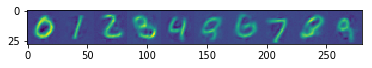

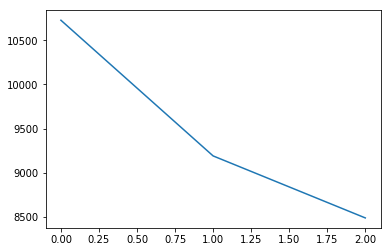

In [11]:
autoencoder = Autoencoder(28*28).to(device)
train(autoencoder, train_dataloader, test_dataloader, epochs=10, flatten=True)

## Convolutional Autoencoder

In [13]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,(3,3),stride=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16,8,(3,3), stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8,16,(3,3), stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16,8,(5,5), stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

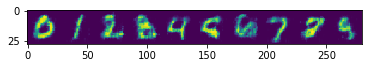

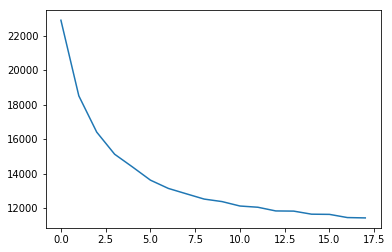

In [ ]:
cnnAutoencoder = CNNAutoencoder().to(device)
train(cnnAutoencoder, train_dataloader, test_dataloader, epochs=20)

## Variational Autoencoder

In [15]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_size):
        super(VariationalAutoencoder, self).__init__()
        self.fc1 = nn.Linear(input_size,512)
        self.fc21 = nn.Linear(512, 20)
        self.fc22 = nn.Linear(512, 20)
        
        
        self.relu = nn.ReLU()
        
        self.fc3 = nn.Linear(20, 512)
        self.fc4 = nn.Linear(512, input_size)
    
    def encode(self, x):
        x = self.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)
        
    def decode(self, z):
        z = self.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(z))
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 *logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
        
    def forward(self,x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x = self.decode(z)
        return x, mu, logvar

In [39]:
def vae_loss_fn(x, recon_x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

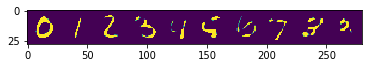

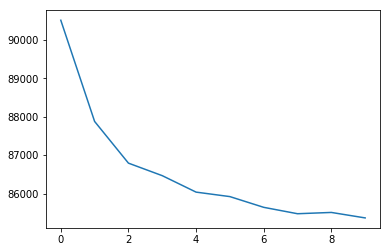

In [44]:
net = VariationalAutoencoder(28*28).to(device)

dataloader = train_dataloader
test_dataloader = test_dataloader
flatten=True

epochs=10

validation_losses = []

optim = torch.optim.Adam(net.parameters())
    
for i in range(epochs):
    for batch in dataloader:
        batch = batch[0].to(device)

        if flatten:
            batch = batch.view(batch.size(0), 28*28)

        optim.zero_grad()
        x,mu,logvar = net(batch)
        loss = vae_loss_fn(batch, x, mu, logvar)
        loss.backward()
        optim.step()
#         print(loss)
    evaluate(validation_losses, lambda x: net(x)[0], test_dataloader, True)

## Conditional Conv VAE

In [48]:
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [49]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 0
learning_rate = 0.001
num_epochs = 50
batch_size = 128

# Architecture
num_classes = 10
num_features = 784
num_latent = 50


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Device: cpu
Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [50]:
##########################
### MODEL
##########################


def to_onehot(labels, num_classes, device):

    labels_onehot = torch.zeros(labels.size()[0], num_classes).to(device)
    labels_onehot.scatter_(1, labels.view(-1, 1), 1)

    return labels_onehot


class ConditionalVariationalAutoencoder(torch.nn.Module):

    def __init__(self, num_features, num_latent, num_classes):
        super(ConditionalVariationalAutoencoder, self).__init__()
        
        self.num_classes = num_classes
        
        
        ###############
        # ENCODER
        ##############
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2

        self.enc_conv_1 = torch.nn.Conv2d(in_channels=1+self.num_classes,
                                          out_channels=16,
                                          kernel_size=(6, 6),
                                          stride=(2, 2),
                                          padding=0)

        self.enc_conv_2 = torch.nn.Conv2d(in_channels=16,
                                          out_channels=32,
                                          kernel_size=(4, 4),
                                          stride=(2, 2),
                                          padding=0)                 
        
        self.enc_conv_3 = torch.nn.Conv2d(in_channels=32,
                                          out_channels=64,
                                          kernel_size=(2, 2),
                                          stride=(2, 2),
                                          padding=0)                     
        
        self.z_mean = torch.nn.Linear(64*2*2, num_latent)
        # in the original paper (Kingma & Welling 2015, we use
        # have a z_mean and z_var, but the problem is that
        # the z_var can be negative, which would cause issues
        # in the log later. Hence we assume that latent vector
        # has a z_mean and z_log_var component, and when we need
        # the regular variance or std_dev, we simply use 
        # an exponential function
        self.z_log_var = torch.nn.Linear(64*2*2, num_latent)
        
        
        
        ###############
        # DECODER
        ##############
        
        self.dec_linear_1 = torch.nn.Linear(num_latent+self.num_classes, 64*2*2)
               
        self.dec_deconv_1 = torch.nn.ConvTranspose2d(in_channels=64,
                                                     out_channels=32,
                                                     kernel_size=(2, 2),
                                                     stride=(2, 2),
                                                     padding=0)
                                 
        self.dec_deconv_2 = torch.nn.ConvTranspose2d(in_channels=32,
                                                     out_channels=16,
                                                     kernel_size=(4, 4),
                                                     stride=(3, 3),
                                                     padding=1)
        
        self.dec_deconv_3 = torch.nn.ConvTranspose2d(in_channels=16,
                                                     out_channels=1,
                                                     kernel_size=(6, 6),
                                                     stride=(3, 3),
                                                     padding=4)        


    def reparameterize(self, z_mu, z_log_var):
        # Sample epsilon from standard normal distribution
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        # note that log(x^2) = 2*log(x); hence divide by 2 to get std_dev
        # i.e., std_dev = exp(log(std_dev^2)/2) = exp(log(var)/2)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def encoder(self, features, targets):
        
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        onehot_targets = onehot_targets.view(-1, self.num_classes, 1, 1)
        
        ones = torch.ones(features.size()[0], 
                          self.num_classes,
                          features.size()[2], 
                          features.size()[3], 
                          dtype=features.dtype).to(device)
        ones = ones * onehot_targets
        x = torch.cat((features, ones), dim=1)
        
        x = self.enc_conv_1(x)
        x = F.leaky_relu(x)
        #print('conv1 out:', x.size())
        
        x = self.enc_conv_2(x)
        x = F.leaky_relu(x)
        #print('conv2 out:', x.size())
        
        x = self.enc_conv_3(x)
        x = F.leaky_relu(x)
        #print('conv3 out:', x.size())
        
        z_mean = self.z_mean(x.view(-1, 64*2*2))
        z_log_var = self.z_log_var(x.view(-1, 64*2*2))
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded, targets):
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        encoded = torch.cat((encoded, onehot_targets), dim=1)        
        
        x = self.dec_linear_1(encoded)
        x = x.view(-1, 64, 2, 2)
        
        x = self.dec_deconv_1(x)
        x = F.leaky_relu(x)
        #print('deconv1 out:', x.size())
        
        x = self.dec_deconv_2(x)
        x = F.leaky_relu(x)
        #print('deconv2 out:', x.size())
        
        x = self.dec_deconv_3(x)
        x = F.leaky_relu(x)
        #print('deconv1 out:', x.size())
        
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features, targets):
        
        z_mean, z_log_var, encoded = self.encoder(features, targets)
        decoded = self.decoder(encoded, targets)
        
        return z_mean, z_log_var, encoded, decoded

    
torch.manual_seed(random_seed)
model = ConditionalVariationalAutoencoder(num_features,
                                          num_latent,
                                          num_classes)
model = model.to(device)
    

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)